<a href="https://colab.research.google.com/github/meashu31/AIML-Capstone-CV9/blob/Vadhi_master/Unet_Models_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Gogle Drive

In [ ]:
pip install segmentation-models

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#------------------------- Load necessary libraries -------------------------#
####------------------------- for loading path -------------------------#
import os
import pickle
from tqdm import tqdm
####------------------------- for DataGenerator -------------------------#
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
####------------------------- for Plotting -------------------------#
import matplotlib.pyplot as plt
####------------------------- for Model -------------------------#
from keras.utils.layer_utils import count_params
from tabulate import tabulate
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import *
from keras.layers import  *
import tensorflow as tf

#import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

IMAGE_HEIGHT=224
IMAGE_WIDTH=224

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
#------------------------- Declare required path -------------------------#
ProjectPath = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/'
CSVPath = os.path.join(ProjectPath,"DataSet_CSV")
Normal = os.path.join(ProjectPath,'Balanced_Data/Normal')
NormalImg = os.path.join(ProjectPath,'Balanced_Data/Normal/image_data/images')
NormalMask = os.path.join(ProjectPath,'Balanced_Data/Normal/mask_data/masks')
Pneumonia = os.path.join(ProjectPath,'Balanced_Data/Pneumonia')
PneumoniaImg = os.path.join(ProjectPath,'Balanced_Data/Pneumonia/image_data/images')
PneumoniaMask = os.path.join(ProjectPath,'Balanced_Data/Pneumonia/mask_data/masks')
RawImg = os.path.join(ProjectPath,'data/image_data/images')
RawMask = os.path.join(ProjectPath,'data/mask_data/masks')

os.chdir(ProjectPath) #changing the current directory path to the project direcotry where the dataset is available
#------------------------- Load CSV to get label info -------------------------#

In [ ]:
#------------------------- Run This code onlt if ID_List.pkl not available -------------------------#
#NormalList = os.listdir(NormalImg)
#PneumoniaList = os.listdir(PneumoniaImg)

#ID_Target = pd.read_csv(os.path.join(CSVPath,"stage_2_train_labels.csv")).reset_index()
#ID_Target = ID_Target.drop(['index','x','y','width','height'],axis=1)

#for i in tqdm(ID_Target.index): 
#  ID = ID_Target.patientId[i]+'.png'
#  Target = ID_Target.Target[i]
#  if Target == 0:
#    if not ID in NormalList:
#      NormalList.append(ID)
#      shutil.copy(RawImg+'/'+ID, NormalImg) #Copy Normal Image
#      shutil.copy(RawMask+'/'+ID, NormalMask) #Copy Normal Mask
#  else:
#    if not ID in PneumoniaList:
#      PneumoniaList.append(ID)
#      shutil.copy(RawImg+'/'+ID, PneumoniaImg) #Copy Pneumonia Image
#      shutil.copy(RawMask+'/'+ID, PneumoniaMask) #Copy Pneumonia Mask

#print('NormalList',len(NormalList))
#print('PneumoniaList',len(PneumoniaList))

#with open(ProjectPath+'/ID_List.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([NormalList, PneumoniaList], f)

In [ ]:
# Getting back the objects:
with open(ProjectPath+'/ID_List.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    NormalList, PneumoniaList = pickle.load(f)

print('NormalList',len(NormalList))
print('PneumoniaList',len(PneumoniaList))

NormalList 20672
PneumoniaList 6012


In [ ]:
#Nom_image_gen_args = dict(validation_split=0.2,rescale=1./255)
#Nom_mask_gen_args = dict(validation_split=0.2,rescale=1./255)
Pne_image_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2,rescale=1./255,zoom_range=0.2)
Pne_mask_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2,rescale=1./255,zoom_range=0.2)

#Nom_image_datagen = ImageDataGenerator(**Nom_image_gen_args)
#Nom_mask_datagen = ImageDataGenerator(**Nom_mask_gen_args)
Pne_image_datagen = ImageDataGenerator(**Pne_image_gen_args)
Pne_mask_datagen = ImageDataGenerator(**Pne_mask_gen_args)
seed = 1

#Nom_image = tf.keras.preprocessing.image.load_img(NormalImg+'/'+NormalList[0])
#Nom_input_img = keras.preprocessing.image.img_to_array(Nom_image)
#Nom_input_img = np.array([Nom_input_img])  # Convert single image to a batch.
#print("Nominal Input image shape:",Nom_input_img.shape)
Pne_image = tf.keras.preprocessing.image.load_img(PneumoniaImg+'/'+PneumoniaList[0])
Pne_input_img = keras.preprocessing.image.img_to_array(Pne_image)
Pne_input_img = np.array([Pne_input_img])  # Convert single image to a batch.
print("Pneumonia Input image shape:",Pne_input_img.shape)

#Nom_mask = tf.keras.preprocessing.image.load_img(NormalMask+'/'+NormalList[0], color_mode="grayscale")
#Nom_input_mask = keras.preprocessing.image.img_to_array(Nom_mask,)
#Nom_input_mask = np.array([Nom_input_mask])  # Convert single image to a batch.
#print("Nominal Input mask shape:",Nom_input_mask.shape)
Pne_mask = tf.keras.preprocessing.image.load_img(PneumoniaMask+'/'+PneumoniaList[0], color_mode="grayscale")
Pne_input_mask = keras.preprocessing.image.img_to_array(Pne_mask,)
Pne_input_mask = np.array([Pne_input_mask])  # Convert single image to a batch.
print("Input mask shape:",Pne_input_mask.shape)

#Nom_image_datagen.fit(Nom_input_img, augment=True, seed=seed)
#Nom_mask_datagen.fit(Nom_input_mask, augment=True, seed=seed)
#Pne_image_datagen.fit(Pne_input_img, augment=True, seed=seed)
#Pne_mask_datagen.fit(Pne_input_mask, augment=True, seed=seed)

Nominal Input image shape: (1, 1024, 1024, 3)
Pneumonia Input image shape: (1, 1024, 1024, 3)
Nominal Input mask shape: (1, 1024, 1024, 1)
Input mask shape: (1, 1024, 1024, 1)


In [ ]:
#def combine_gen(*gens):
#    while True:
#        for g in gens:
#            yield next(g)

In [ ]:
#------------------------- Train DataSetGenerator -------------------------#
#train_Nom_image_generator = Nom_image_datagen.flow_from_directory("Balanced_Data/Normal/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=32,shuffle=True,subset='training',seed=seed)
#train_Nom_mask_generator = Nom_mask_datagen.flow_from_directory("Balanced_Data/Normal/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=32,shuffle=True,subset='training',seed=seed)

#train_Pne_image_generator = Pne_image_datagen.flow_from_directory("Balanced_Data/Pneumonia/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=32,shuffle=True,subset='training',seed=seed)
#train_Pne_mask_generator = Pne_mask_datagen.flow_from_directory("Balanced_Data/Pneumonia/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=32,shuffle=True,subset='training',seed=seed)
#------------------------- Validation DataSetGenerator -------------------------#
#validation_Nom_image_generator = Nom_image_datagen.flow_from_directory("Balanced_Data/Normal/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=32,shuffle=True,subset='validation',seed=seed)
#validation_Nom_mask_generator = Nom_mask_datagen.flow_from_directory("Balanced_Data/Normal/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=32,shuffle=True,subset='validation',seed=seed)

#validation_Pne_image_generator = Pne_image_datagen.flow_from_directory("Balanced_Data/Pneumonia/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=32,shuffle=True,subset='validation',seed=seed)
#validation_Pne_mask_generator = Pne_mask_datagen.flow_from_directory("Balanced_Data/Pneumonia/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=32,shuffle=True,subset='validation',seed=seed)

#----- Zip Data----

Found 16538 images belonging to 1 classes.
Found 16537 images belonging to 1 classes.
Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 4134 images belonging to 1 classes.
Found 4134 images belonging to 1 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.


In [ ]:
#train_generator = zip(combine_gen(train_Nom_image_generator,train_Pne_image_generator),combine_gen(train_Nom_mask_generator,train_Pne_mask_generator))
#validation_generator = zip(combine_gen(validation_Nom_image_generator,validation_Pne_image_generator),combine_gen(validation_Nom_mask_generator,validation_Pne_mask_generator))

## Backboned-UNet

In [ ]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [ ]:
def create_model(Backbone='vgg16',pretrained=True,ShowSummery=False,TrainModel=True,TestModel=True):
  # define model
  print("-------------------Generating UNet Model----------------------")
  model = Unet(Backbone, encoder_weights='imagenet', input_shape=(224, 224, 3))
  ##-------------------getLast layer and add reshape----------------------
  OneThrird = int(len(model.layers)/3)
  for layer in model.layers[:OneThrird]:
      layer.trainable=False
  for layer in model.layers[OneThrird:]:
      layer.trainable=True

  # Model Overview
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)
  print()
  print(tabulate([['Model', 'UNet'],\
                          ['BackBone', Backbone],\
                          ['Number of Layers', len(model.layers)],\
                          ['Total params', model.count_params()],\
                          ['Trainable params', trainable_count],\
                          ['Non-trainable params', non_trainable_count]],\
                          headers=['Header', 'Value'], tablefmt='orgtbl'))
  print()
  #If Choosen Show Summery
  
  if ShowSummery: 
    print("-------------------Model Summery----------------------")
    model.summary()
  if TrainModel:
    print("-------------------Training Model----------------------")
    # Compile model
    Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
    model.compile(loss=jaccard_distance_loss, optimizer='Adam', metrics=[['accuracy',iou_loss_core]])
    # checkpoint
    filepath = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/' + Backbone + "/"
    checkpoint = ModelCheckpoint(filepath+"model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
    stop = EarlyStopping(monitor="loss", patience=2, mode="min")
    batch_size = 6
    history = model.fit_generator(train_generator,
                    epochs=1,
                    use_multiprocessing = True, workers = 6,
                    steps_per_epoch = 21348//(batch_size**2),
                    validation_data=validation_generator,
                    validation_steps = 5336//(batch_size**2),
                    callbacks= [checkpoint, stop])
    #--------------------- Plot Loss and Accuracy --------------
    fig, axs = plt.subplots(1, 3, figsize = (15, 4))
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_IOU = history.history['iou_loss_core']
    validation_IOU = history.history['val_iou_loss_core']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epoch_count = range(1, len(training_IOU) + 1)
    axs[0].plot(epoch_count, training_loss, 'r--')
    axs[0].plot(epoch_count, validation_loss, 'b-')
    axs[0].legend(['Training loss', 'Validation loss'])
    axs[1].plot(epoch_count, training_IOU, 'r--')
    axs[1].plot(epoch_count, validation_IOU, 'b-')
    axs[1].legend(['Training iou_loss_core', 'Validation iou_loss_core'])
    axs[2].plot(epoch_count, training_accuracy, 'r--')
    axs[2].plot(epoch_count, validation_accuracy, 'b-')
    axs[2].legend(['Training Accuracy', 'Validation Accuracy'])
  #---------------- DO NOT USE TEST AS OF NOW --------------------
  if TestModel:
    test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
    test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)
    model.compile('Adam', loss=jaccard_distance_loss, metrics=['accuracy',iou_score])
    n = 0
    sample_image = test_gen[n][0][0]
    sample_image_redim = np.expand_dims(sample_image, axis=0)
    region = model.predict(sample_image_redim)
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
    ax1.imshow(sample_image[:,:,0], cmap = plt.cm.bone)
    ax1.set_title('Input Image')
    ax1.axis('off')
    ax2.imshow(test_gen[n][1][0], cmap = plt.cm.bone)
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    ax3.imshow(region[0], cmap = plt.cm.bone)
    ax3.set_title('Predicted Mask (no threshold applied)')
    ax3.axis('off')
    plt.show()
  print('----------------------- I AM DONE -----------------------')

In [ ]:
print(tabulate([['UNet', 'VGG-16', 67, 23752273],\
                ['UNet', 'VGG-19', 70, 29061969],\
                ['UNet', 'ResNet-18', 128, 14340570],\
                ['UNet', 'ResNet-34', 200, 24456154],\
                ['UNet', 'ResNet-50', 232, 32561114],\
                ['UNet', 'ResNet-101', 419, 51605466],\
                ['UNet', 'ResNet-152', 606, 67295194],\
                ['UNet', 'DenseNet-121', 469, 12144977],\
                ['UNet', 'DenseNet-169', 637, 19519825],\
                ['UNet', 'DenseNet-201', 749, 26378577],\
                ['UNet', 'Inception-V3', 353, 29933105],\
                ['UNet', 'Inception-ResNet-V2', 822, 62061553],\
                ['UNet', 'MobileNet', 129, 8336337]],
                headers=['Model', 'Backbone', 'Number of Layers', 'Total Parameters'], tablefmt='orgtbl',stralign="center", numalign="center"))

|  Model  |      Backbone       |  Number of Layers  |  Total Parameters  |
|---------+---------------------+--------------------+--------------------|
|  UNet   |       VGG-16        |         67         |      23752273      |
|  UNet   |       VGG-19        |         70         |      29061969      |
|  UNet   |      ResNet-18      |        128         |      14340570      |
|  UNet   |      ResNet-34      |        200         |      24456154      |
|  UNet   |      ResNet-50      |        232         |      32561114      |
|  UNet   |     ResNet-101      |        419         |      51605466      |
|  UNet   |     ResNet-152      |        606         |      67295194      |
|  UNet   |    DenseNet-121     |        469         |      12144977      |
|  UNet   |    DenseNet-169     |        637         |      19519825      |
|  UNet   |    DenseNet-201     |        749         |      26378577      |
|  UNet   |    Inception-V3     |        353         |      29933105      |
|  UNet   | 

In [ ]:
#------------------------- Load necessary libraries -------------------------#
from ipywidgets import widgets, Layout, Button, Box, Dropdown, Label,Output,interact, interactive_output
from IPython.display import clear_output
#------------------------- Load widgets -------------------------#
BackBoneLabel = Label(value='Select Backbone')
BackboneDrop = Dropdown(options=[('Select', ""),("VGG-16", "vgg16"),("VGG-19", "vgg19"),
                           ("ResNet-18","resnet18"),("ResNet-34","resnet34"),
                           ("ResNet-50","resnet50"),("ResNet-101","resnet101"),
                           ("ResNet-152","resnet152"),("DenseNet-121","densenet121"),
                           ("DenseNet-169","densenet169"),("DenseNet-201","densenet201"),
                           ("Inception V3","inceptionv3"),("Inception ResNet V2","inceptionresnetv2"),
                           ("MobileNet","mobilenet")],value='')
PreTrainLabel = Label(value='Use PreTrained Weights')
PreTrainedDrop = Dropdown(options=[('Yes', True),("No", False)],value=True)
SummeryLabel = Label(value='Show Model Summary')
SummeryDrop = Dropdown(options=[('Yes', True),("No", False)],value=False)
TrainLabel = Label(value='Train Model')
TrainModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
TestLabel = Label(value='Test Model')
TestModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
GenerateModelButton = widgets.Button(description="Generate Model",disabled=False,button_style='success',tooltip='Click to generate model')
#------------------------- Function on Selection -------------------------#
def OnSelection(BackBoneSelection,PreTrainSelection,SummerySelection,TrainSelection,TestSelection):
  PreTrainStr = None
  ShowSummaryStr = None
  TrainModelStr = None
  TestModelStr = None
  print()
  if BackBoneSelection == "":
    print("Please select a Backbone of your choice")
  else:
    PreTrainStr = "Trained" if PreTrainSelection else "UnTrained"
    ShowSummaryStr = "be" if SummerySelection else "not be"
    TrainModelStr = "be" if TrainSelection else "not be"
    TestModelStr = "be" if TestSelection else "not be"
    print("UNet Model with",PreTrainStr,BackBoneSelection,"backbone will be loaded, Model Summary will",ShowSummaryStr,"displayed, will", TrainModelStr, "trained and will",TestModelStr, "tested with new data.")
    print()
    print("If OK with above configuration, Click Generate Model (OR) Choose required configuration from GUI")
    print()
    display(GenerateModelButton)
#------------------------- Function at Button click -------------------------#
def on_button_clicked(b):
  create_model(Backbone=BackboneDrop.value,pretrained=PreTrainedDrop.value,ShowSummery=SummeryDrop.value,TrainModel=TrainModel.value,TestModel=TestModel.value)
GenerateModelButton.on_click(on_button_clicked)
#------------------------- Make widget -------------------------#
out = interactive_output(OnSelection, {"BackBoneSelection":BackboneDrop, "PreTrainSelection":PreTrainedDrop, "SummerySelection":SummeryDrop, "TrainSelection":TrainModel, "TestSelection":TestModel})
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')
form_items = [
    Box([BackBoneLabel,BackboneDrop], layout=form_item_layout),
    Box([PreTrainLabel, PreTrainedDrop], layout=form_item_layout),
    Box([SummeryLabel, SummeryDrop], layout=form_item_layout),
    Box([TrainLabel, TrainModel], layout=form_item_layout),
    Box([TestLabel, TestModel], layout=form_item_layout)]
GUI = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='27%'))

In [ ]:
display(GUI, out)

Box(children=(Box(children=(Label(value='Select Backbone'), Dropdown(options=(('Select', ''), ('VGG-16', 'vgg1…

Output()

-------------------Generating UNet Model----------------------

| Header               | Value     |
|----------------------+-----------|
| Model                | UNet      |
| BackBone             | mobilenet |
| Number of Layers     | 128       |
| Total params         | 8336337   |
| Trainable params     | 8044369   |
| Non-trainable params | 291968    |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
593/593 [==============================] - 630s 1s/step - loss: 0.0877 - accuracy: 0.4951 - iou_loss_core: 0.9887 - val_loss: 0.0043 - val_accuracy: 0.5128 - val_iou_loss_core: 1.0006

Epoch 00001: loss improved from inf to 0.08773, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/mobilenet/model-0.09.h5
----------------------- I AM DONE -----------------------


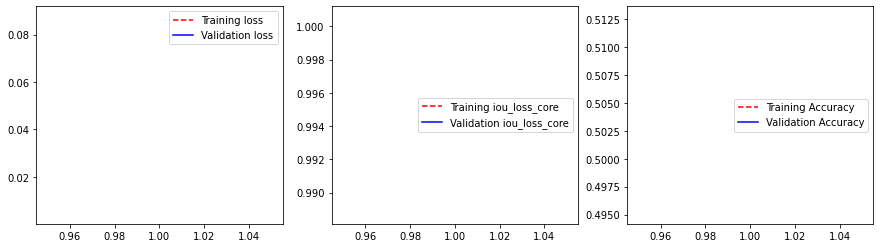

In [ ]:
create_model(Backbone='mobilenet' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

In [ ]:
create_model(Backbone='densenet121' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

In [ ]:
create_model(Backbone='resnet50' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

In [ ]:
create_model(Backbone='inceptionv3' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

In [ ]:
create_model(Backbone='vgg19' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)